# Coastal Erosion Simulation

In [31]:
#necessary plotting imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# animation imports
from matplotlib import animation, rc
import matplotlib.animation as anm
import matplotlib.collections as clt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Land Degradation Over Time

To effectively develop an algorithm for optimal tree placement, we must first create some sort of simulation of coastal erosion. We can use a 2D array as our primary data structure. We can prepopulate the array with a few rows just to illustrate the concept. A '1' will represent land, and a '0' will represent water.

In [32]:
coast = [
    [0,0,0,0,0,0,0],
    [0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0],
    [0,1,1,1,1,1,0],
    [0,1,1,1,1,1,0]]

Next, we can make a function to perform a timestep. In this timestep, we will show the water eroding the non-landlocked elements in our coast. Computationally, we can subtract an arbitrary fraction from the FIRST non-zero element in each COLUMN. Note that the rectangular property of the 2D array is important for this; since each nested list has the same amount of elements, we can iterate by index down each column.

In [33]:
def timestep(coast):
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if coast[row_idx][col_idx] > 0: # if there is land, begin the coast checks               
                if row_idx != 0:
                    if coast[row_idx-1][col_idx] <= 0:
                        coast[row_idx][col_idx] -= 0.16
                if col_idx != 0:
                    if coast[row_idx][col_idx-1] <= 0:
                        coast[row_idx][col_idx] -= 0.06
                if col_idx != len(coast[0])-1:
                    if coast[row_idx][col_idx+1] <= 0:
                        coast[row_idx][col_idx] -= 0.06
                
                if coast[row_idx][col_idx] < 0:
                    coast[row_idx][col_idx] = 0

The iteration process looks a bit confusing, but the algorithm can be described as follows:

Go down each column in the array, starting from the top left. If the value is > 0, subtract some arbitrary decimal, stop iterating, and move to the next column. Proceed this way until you have done every column.

Additionally, it will be useful to have some way to quantify the effects of erosion, and the efficacy of various tree placement algorithms. We can sum the `coast` array to get a figure for remaining land area, and track how this figure changes over multiple iterations.

In [34]:
area_progression = []
area_progression.append(np.sum(coast))

To better visualize this effect, we can make some plots. We will plot overlapping circles to represent a contiguous landmass, each one with the same radius at first. As we take timesteps, we will reduce the radius to reflect shrinking area of land.

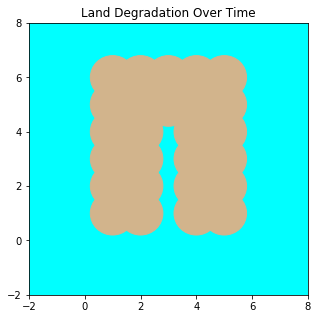

In [35]:
fig, ax1 = plt.subplots(1,1,figsize=(5,5))
points = {} # dictionary to keep track of patches by coordinates!
            # this only works because of the 2D array - no two circles
            # will ever have the same coordinates. hideous errors
            # would occur if not for this.
            
ax1.set_xlim([-2,8])
ax1.set_ylim([-2,8])

ax1.set_title('Land Degradation Over Time')
ax1.set_facecolor('aqua')
patches = []  
for row in range(len(coast)):
    for col in range(len(coast[0])):
        p = mpatches.Circle((col, row), coast[row][col]*0.8, color="tan") # key = coords, val = patch object
        patches.append(p)
        points[(row,col)] = p
        ax1.add_patch(p)

frames = 14
z = 0.5*np.random.randn(frames,3)
collection = clt.PatchCollection(patches, cmap=plt.cm.jet, alpha=0.4)
collection.set_array(z[0,:])

ax1.add_collection(collection);

In [36]:
def graphical_timestep(coast):
    timestep(coast)
    for row in range(len(coast)):
        for col in range(len(coast[0])):
            points[(row,col)].set_radius(coast[row][col]*0.8)

def animate(frame):
    patches = []
    graphical_timestep(coast)
    area_progression.append(np.sum(coast))
    ax1.figure
    # update animation
    collection.set_paths(patches)
    collection.set_array(z[frame,:])

In [37]:
anim = anm.FuncAnimation(fig, animate,
                               frames=10, interval=700, blit=False)
HTML(anim.to_html5_video())

This model simulates water eroding the coast over time. Now, we can implement tree planting as a means to slow coastal erosion! We will create another 2D array of the same shape as our coast array, with "True" indicating the presence of a tree at certain coordinates and "False indicating the absence of one.

## Plotting Trees to Prevent Land Loss

As a proof of concept, we will randomly populate treemap. Each cell will have a ~25% chance of containing a tree.

In [38]:
# initialize tree array
treemap = np.zeros((len(coast), len(coast[0])), dtype=bool)

import random
for row_idx in range(len(treemap)): # loops to check every element
    for col_idx in range(len(treemap[row_idx])): # in the 2d array.
        r = random.random()
        if r >= 0.75:
            treemap[row_idx][col_idx] = True
treemap

array([[False, False, False, False, False, False,  True],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False,  True],
       [False,  True,  True, False, False, False, False],
       [ True, False,  True,  True, False, False,  True],
       [False, False, False, False, False,  True, False],
       [False,  True, False, False,  True,  True, False]])

We can now reinitialize our coast, and simulate erosion again. 

In [39]:
coast = [
    [0,0,0,0,0,0,0],
    [0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0],
    [0,1,1,1,1,1,0],
    [0,1,1,1,1,1,0]]

tree_area_prog = []

We must also amend our timestep algorithm to reduce erosion rates on cells with trees.If there is a tree on a land-cell, it erodes more slowly. If there is a tree between a land-cell and a water-cell, it also erodes more slowly.

In [40]:
def timestep(coast):
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if coast[row_idx][col_idx] > 0: # if there is land, begin the coast checks
                # the coast checks are partitioned in this way to prevent index errors!
                # the top row checks only the left and right points
                if row_idx != 0:
                    if coast[row_idx-1][col_idx] <= 0:
                        if treemap[row_idx-1][col_idx]:
                            coast[row_idx][col_idx] -= 0.06
                        else:
                            coast[row_idx][col_idx] -= 0.16
                # the leftmost column checks only the right and front points
                if col_idx != 0:
                    if coast[row_idx][col_idx-1] <= 0:
                        if treemap[row_idx][col_idx-1]:
                            coast[row_idx][col_idx] -= 0.02
                        else:
                            coast[row_idx][col_idx] -= 0.06
                # the rightmost column checks only the left and front points
                if col_idx != len(coast[0])-1:
                    if coast[row_idx][col_idx+1] <= 0:
                        if treemap[row_idx][col_idx+1]:
                            coast[row_idx][col_idx] -= 0.02
                        else:
                            coast[row_idx][col_idx] -= 0.06
                
                if coast[row_idx][col_idx] < 0:  # fixes over-subtraction
                    coast[row_idx][col_idx] = 0

We can now resimulate our erosion, adding markers for the presence of trees.

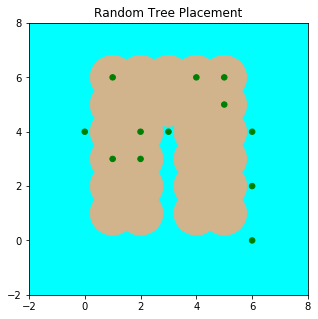

In [41]:
fig, ax2 = plt.subplots(1,figsize=(5,5))
points = {} # dictionary to keep track of patches by coordinates!
            # this only works because of the 2D array - no two circles
            # will ever have the same coordinates. hideous errors
            # would occur if not for this.
            
ax2.set_title('Random Tree Placement')            
ax2.set_facecolor('aqua')
ax2.set_xlim([-2,8])
ax2.set_ylim([-2,8])
            
for row in range(len(coast)):
    for col in range(len(coast[0])):
        p = mpatches.Circle((col, row), coast[row][col]*0.8, color="tan") # key = coords, val = patch object
        points[(row,col)] = p
        ax2.add_patch(p)

for row in range(len(treemap)):
    for col in range(len(treemap[0])):
        if treemap[row][col]:
            t = mpatches.Circle((col, row), 0.1, color="green")
            ax2.add_patch(t)

y = 0.5*np.random.randn(frames,3)
land_collection = clt.PatchCollection(patches, cmap=plt.cm.jet, alpha=0.4)
land_collection.set_array(z[0,:])
tree_collection = clt.PatchCollection(patches, cmap=plt.cm.jet, alpha=0.4)
tree_collection.set_array(y[0,:])

tree_area_prog.append(np.sum(coast))

In [42]:
def animate(frame):
    patches = []
    #for p in range(3):
    graphical_timestep(coast)
    tree_area_prog.append(np.sum(coast))
    ax2.figure
        #circle = plt.Circle((x[frame,p], y[frame,p]), radius)
        #patches.append(circle)
    land_collection.set_paths(patches)
    land_collection.set_array(z[frame,:])    
    tree_collection.set_paths(patches)
    tree_collection.set_array(z[frame,:])
    

In [43]:
anim = anm.FuncAnimation(fig, animate,
                               frames=10, interval=700, blit=False)
HTML(anim.to_html5_video())

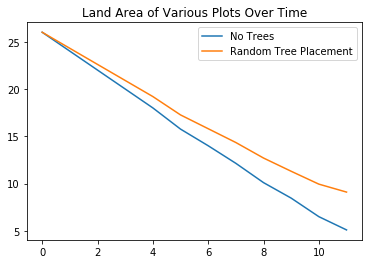

In [44]:
plt.plot(area_progression, label = "No Trees")
plt.plot(tree_area_prog, label="Random Tree Placement")
plt.title("Land Area of Various Plots Over Time")
plt.legend()
plt.show()

Obviously, the presence of trees in any configuration is better than none - but we can do better! Now, we will place 12 trees manually in vulnerable areas.

## Tree Placement Based on Human Intuition

In [45]:
coast = [
    [0,0,0,0,0,0,0],
    [0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0],
    [0,1,1,1,1,1,0],
    [0,1,1,1,1,1,0]]

treemap = np.zeros((len(coast), len(coast[0])), dtype=bool)

human_placement_area_prog = []

In [46]:
treemap[1][1] = True
treemap[1][2] = True
treemap[2][1] = True
treemap[2][2] = True
treemap[1][4] = True
treemap[1][5] = True
treemap[2][4] = True
treemap[2][5] = True
treemap[3][2] = True
treemap[3][4] = True
treemap[4][2] = True
treemap[4][4] = True

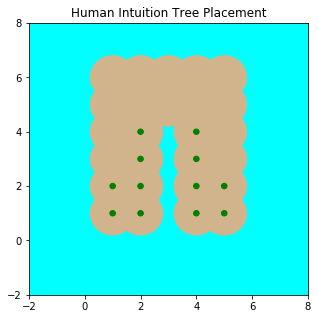

In [47]:
fig, ax3 = plt.subplots(1,figsize=(5,5))
points = {} # dictionary to keep track of patches by coordinates!
            # this only works because of the 2D array - no two circles
            # will ever have the same coordinates. hideous errors
            # would occur if not for this.
            
ax3.set_title('Human Intuition Tree Placement')          
ax3.set_facecolor('aqua')

ax3.set_xlim([-2,8])
ax3.set_ylim([-2,8])

for row in range(len(coast)):
    for col in range(len(coast[0])):
        p = mpatches.Circle((col, row), coast[row][col]*0.8, color="tan") # key = coords, val = patch object
        points[(row,col)] = p
        ax3.add_patch(p)

for row in range(len(treemap)):
    for col in range(len(treemap[0])):
        if treemap[row][col]:
            t = mpatches.Circle((col, row), 0.1, color="green")
            ax3.add_patch(t)

land_collection = clt.PatchCollection(patches, cmap=plt.cm.jet, alpha=0.4)
land_collection.set_array(z[0,:])
tree_collection = clt.PatchCollection(patches, cmap=plt.cm.jet, alpha=0.4)
tree_collection.set_array(y[0,:])

In [48]:
human_placement_area_prog.append(np.sum(coast))

In [49]:
def animate(frame):
    patches = []
    #for p in range(3):
    graphical_timestep(coast)
    human_placement_area_prog.append(np.sum(coast))
    ax3.figure
        #circle = plt.Circle((x[frame,p], y[frame,p]), radius)
        #patches.append(circle)
    land_collection.set_paths(patches)
    land_collection.set_array(z[frame,:])    
    tree_collection.set_paths(patches)
    tree_collection.set_array(z[frame,:])
    

In [50]:
anim = anm.FuncAnimation(fig, animate,
                               frames=10, interval=700, blit=False)
HTML(anim.to_html5_video())

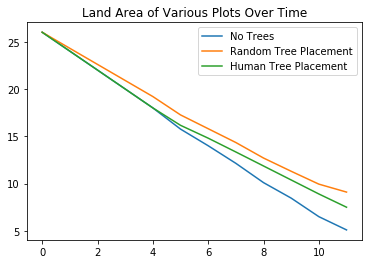

In [51]:
plt.plot(area_progression, label = "No Trees")
plt.plot(tree_area_prog, label="Random Tree Placement")
plt.plot(human_placement_area_prog, label="Human Tree Placement")
plt.title("Land Area of Various Plots Over Time")
plt.legend()
plt.show()

The intuitively placed trees fared even worse than this batch of randomized trees!  

Let's now generate an algorithm to place trees in the best places. From our experimentation, we can see that erosion is minimized by placing trees next to as many exposed faces of land as possible - often, this will occur IN water. We can pass through each cell in the array and check to see if that cell contains water. If it does, we will plant a preallotted number of trees (n) in each cell, prioritizing those with most exposed faces of land.

We will also make a helper function to determine the number of exposed faces of land a cell of water has.

## Algorithmic Tree Placement

In [52]:
def num_faces(coast, row, col):
    faces = 0
    if coast[row][col] == 0:
        if row-1 >= 0:
            if coast[row-1][col] > 0:
                faces += 1
        if row+1 <= len(coast)-1:
            if coast[row+1][col] > 0:
                faces += 1
        if col-1 >= 0:
            if coast[row][col-1] > 0:
                faces += 1
        if col+1 <= len(coast[0])-1:
            if coast[row][col+1] > 0:
                faces += 1
    return faces

In [53]:
def place_trees(coast, treemap, n):
    trees_to_place = n
    
    # first, check for four open faces (only possible with a mini lake, but still)
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if num_faces(coast,row_idx,col_idx) == 4:
                treemap[row_idx][col_idx] = True
                trees_to_place -= 1
                # also, we need to ensure we don't overplant.
                # check if we have any trees left after every planting -
                # if not, break immediately.
                if trees_to_place == 0:
                    return
    
    # next, check for three open faces.
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if num_faces(coast,row_idx,col_idx) == 3:
                treemap[row_idx][col_idx] = True
                trees_to_place -= 1
                if trees_to_place == 0:
                    return
    
    # now two open faces...
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if num_faces(coast,row_idx,col_idx) == 2:
                treemap[row_idx][col_idx] = True
                trees_to_place -= 1
                if trees_to_place == 0:
                    return
                
    # and one open face.
    for row_idx in range(len(coast)): # loops to check every element
        for col_idx in range(len(coast[row_idx])): # in the 2d array.
            if num_faces(coast,row_idx,col_idx) == 1:
                treemap[row_idx][col_idx] = True
                trees_to_place -= 1
                if trees_to_place == 0:
                    return

In [54]:
coast = [
    [0,0,0,0,0,0,0],
    [0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0],
    [0,1,1,1,1,1,0],
    [0,1,1,1,1,1,0]]

treemap = np.zeros((len(coast), len(coast[0])), dtype=bool)

place_trees(coast, treemap, 12)

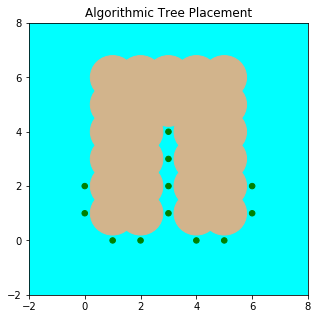

In [55]:
fig, ax4 = plt.subplots(1,figsize=(5,5))
points = {} # dictionary to keep track of patches by coordinates!
            # this only works because of the 2D array - no two circles
            # will ever have the same coordinates. hideous errors
            # would occur if not for this.

ax4.set_title('Algorithmic Tree Placement')   
ax4.set_facecolor('aqua')

ax4.set_xlim([-2,8])
ax4.set_ylim([-2,8])
            
for row in range(len(coast)):
    for col in range(len(coast[0])):
        p = mpatches.Circle((col, row), coast[row][col]*0.8, color="tan") # key = coords, val = patch object
        points[(row,col)] = p
        ax4.add_patch(p)

for row in range(len(treemap)):
    for col in range(len(treemap[0])):
        if treemap[row][col]:
            t = mpatches.Circle((col, row), 0.1, color="green")
            ax4.add_patch(t)
land_collection = clt.PatchCollection(patches, cmap=plt.cm.jet, alpha=0.4)
land_collection.set_array(z[0,:])
tree_collection = clt.PatchCollection(patches, cmap=plt.cm.jet, alpha=0.4)
tree_collection.set_array(y[0,:])

In [56]:
algo_tree_area_prog = [np.sum(coast)]

In [57]:
def animate(frame):
    patches = []
    #for p in range(3):
    graphical_timestep(coast)
    algo_tree_area_prog.append(np.sum(coast))
    ax4.figure
        #circle = plt.Circle((x[frame,p], y[frame,p]), radius)
        #patches.append(circle)
    land_collection.set_paths(patches)
    land_collection.set_array(z[frame,:])    
    tree_collection.set_paths(patches)
    tree_collection.set_array(z[frame,:])

In [58]:
anim = anm.FuncAnimation(fig, animate,
                               frames=10, interval=700, blit=False)
HTML(anim.to_html5_video())

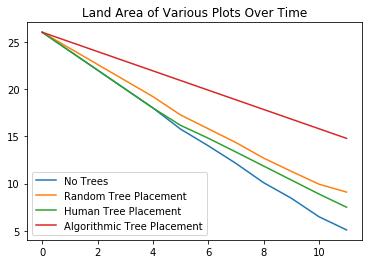

In [59]:
plt.plot(area_progression, label = "No Trees")
plt.plot(tree_area_prog, label="Random Tree Placement")
plt.plot(human_placement_area_prog, label="Human Tree Placement")
plt.plot(algo_tree_area_prog, label= "Algorithmic Tree Placement")
plt.title("Land Area of Various Plots Over Time")
plt.legend()
plt.show()

Our algorithmic placement far outperformed both the randomized placement and the human intuition.

In [ ]:
import numpy as np
import nbinteract as nbi
nbi.publish('danellsworth/git/Coastal Erosion Website', 'animation_erosion_model.ipynb')

<IPython.core.display.Javascript object>